In [1]:
import nltk
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer ,ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
import keras

In [2]:
import numpy as np 
import pandas as pd

df = pd.read_csv('Reviews.csv')

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Examining the dataset

In [3]:
df.drop(['ProductId', 'UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'], axis=1)

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...
...,...,...,...
568449,568450,5,Great for sesame chicken..this is a good if no...
568450,568451,2,I'm disappointed with the flavor. The chocolat...
568451,568452,5,"These stars are small, so you can give 10-15 o..."
568452,568453,5,These are the BEST treats for training and rew...


In [4]:
#Checking for null values
df['Score'].isnull().sum()

0

In [5]:
#checking count of labels
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [6]:
rating_prec = df['Score'].value_counts()/len(df) * 100
rating_prec

5    63.878871
4    14.188483
1     9.194763
3     7.501047
2     5.236835
Name: Score, dtype: float64

C:\Users\masen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Score', ylabel='count'>

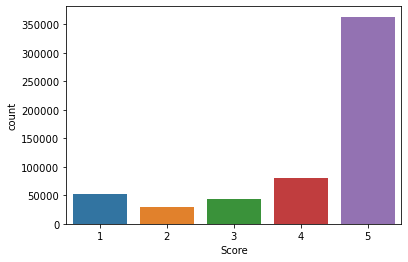

In [7]:
sns.countplot(df['Score'])

C:\Users\masen\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Text', ylabel='Density'>

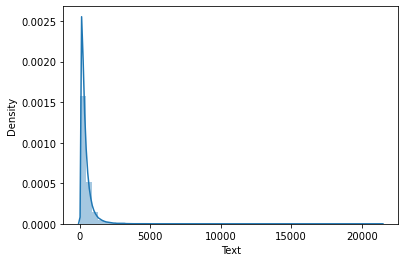

In [8]:
# finding length of texts
lens = df['Text'].str.len()
sns.distplot(lens)

In [9]:
np.median(df['Text'].str.len())

302.0

# Data Preprocessing

In [10]:
def apply_sentiment(Rating):
    if(Rating <=2 ):
        return 0
    else:
        return 1

In [11]:
Y = df['Score'].apply(apply_sentiment)
Y

0         1
1         0
2         1
3         0
4         1
         ..
568449    1
568450    0
568451    1
568452    1
568453    1
Name: Score, Length: 568454, dtype: int64

In [12]:
import re
def clean_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [13]:
stop_words = set(stopwords.words('english'))
negative_stop_words = set(word for word in stop_words if "n't" in word or 'no' in word)
stop_words = stop_words - negative_stop_words

In [14]:
stemmer = SnowballStemmer(language='english')
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review =  clean_text(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [stemmer.stem(token) for token in review] #Stemming
    review = " ".join(review)
    review.strip()
    return review
df['Text'] = df['Text'].apply(lambda x: preprocess_text(x))

In [15]:
stemmer = SnowballStemmer(language='english')
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = clean_text(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [stemmer.stem(token) for token in review] #Stemming
    review = " ".join(review)
    review.strip()
    return review
df['Text'] = df['Text'].apply(lambda x: preprocess_text(x))

In [16]:
df['Text'].head()

0    bought sever vital dog food product found good...
1    product arriv label jumbo salt peanut peanut a...
2    confect around centuri light pillowi citrus ge...
3    look secret ingredi robitussin believ found go...
4    great taffi great price wide assort yummi taff...
Name: Text, dtype: object

In [17]:
texts = df.Text.values
print(texts)

['bought sever vital dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better'
 'product arriv label jumbo salt peanut peanut actual small size unsalt not sure error vendor intend repr product jumbo'
 'confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven not chewi flavor high recommend yummi treat familiar stori c lewi lion witch wardrob treat seduc edmund sell brother sister witch'
 ...
 'star small give one train session tri train dog ceaser dog treat made puppi hyper compar ingredi know littl star basic food ingredi without preserv food color sweet potato flavor also not make hand smell like dog food'
 'best treat train reward dog good groom lower calori love doggi sweet potato seem favorit wet nose treat'
 'satisfi product adverti use cereal raw vinegar general sweetner']


# Data normalization

In [18]:
def normalize(score):
    return score - 1

In [19]:
df["Score"] = df["Score"].apply(normalize)

In [20]:
df = df.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1)

In [21]:
df['Text'].replace('', np.nan, inplace=True)
df.dropna(subset=['Text'], inplace=True)

In [22]:
df.head()

,Score,Text
0,4,bought sever vital dog food product found good...
1,0,product arriv label jumbo salt peanut peanut a...
2,3,confect around centuri light pillowi citrus ge...
3,1,look secret ingredi robitussin believ found go...
4,4,great taffi great price wide assort yummi taff...


In [23]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
print("Training data size: ", train_df.shape)
print("Test data size: ", test_df.shape)

Training data size:  (453674, 2)
Test data size:  (113419, 2)


# Model Creation

#### Bidirectional LSTM use with embedding layer

In [24]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

vocab_size = len(tokenizer.word_index) + 1
max_review_length = 100
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

In [25]:
from numpy import array, asarray, zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_review_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          8012000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
Total params: 8,173,805
Trainable params: 8,173,805
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_review_length))
model.add(Bidirectional(GRU(100)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          8012000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              121200    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 8,134,205
Trainable params: 8,134,205
Non-trainable params: 0
_________________________________________________________________


In [28]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

In [29]:
from keras.layers import Bidirectional
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 130, 32)           192032    
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              106400    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 299,437
Trainable params: 299,437
Non-trainable params: 0
_________________________________________________________________


In [30]:
from keras.utils import np_utils
y_train =keras.utils.np_utils.to_categorical(y_train)

In [31]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
2836/2836 [==============================] - 862s 300ms/step - loss: 0.7890 - accuracy: 0.7105 - val_loss: 0.7294 - val_accuracy: 0.7285
Epoch 2/5
2836/2836 [==============================] - 802s 283ms/step - loss: 0.6983 - accuracy: 0.7403 - val_loss: 0.6940 - val_accuracy: 0.7421
Epoch 3/5
2836/2836 [==============================] - 819s 289ms/step - loss: 0.6521 - accuracy: 0.7565 - val_loss: 0.6678 - val_accuracy: 0.7518
Epoch 4/5
2836/2836 [==============================] - 836s 295ms/step - loss: 0.6144 - accuracy: 0.7707 - val_loss: 0.6538 - val_accuracy: 0.7573
Epoch 5/5
2836/2836 [==============================] - 852s 301ms/step - loss: 0.5830 - accuracy: 0.7837 - val_loss: 0.6418 - val_accuracy: 0.7636


In [32]:
history2 = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
11342/11342 [==============================] - 1246s 110ms/step - loss: 0.5884 - accuracy: 0.7822 - val_loss: 0.6508 - val_accuracy: 0.7615
Epoch 2/5
11342/11342 [==============================] - 1291s 114ms/step - loss: 0.5471 - accuracy: 0.7988 - val_loss: 0.6265 - val_accuracy: 0.7748
Epoch 3/5
11342/11342 [==============================] - 1386s 122ms/step - loss: 0.5094 - accuracy: 0.8148 - val_loss: 0.6279 - val_accuracy: 0.7804
Epoch 4/5
11342/11342 [==============================] - 1192s 105ms/step - loss: 0.4727 - accuracy: 0.8287 - val_loss: 0.6348 - val_accuracy: 0.7797
Epoch 5/5
11342/11342 [==============================] - 1259s 111ms/step - loss: 0.4389 - accuracy: 0.8420 - val_loss: 0.6404 - val_accuracy: 0.7822


In [33]:
history3 = model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
5671/5671 [==============================] - 2321s 409ms/step - loss: 0.3855 - accuracy: 0.8631 - val_loss: 0.6710 - val_accuracy: 0.7852
Epoch 2/5
5671/5671 [==============================] - 1928s 340ms/step - loss: 0.3588 - accuracy: 0.8736 - val_loss: 0.6874 - val_accuracy: 0.7872
Epoch 3/5
5671/5671 [==============================] - 1596s 281ms/step - loss: 0.3348 - accuracy: 0.8831 - val_loss: 0.7179 - val_accuracy: 0.7861
Epoch 4/5
5671/5671 [==============================] - 1517s 268ms/step - loss: 0.3127 - accuracy: 0.8909 - val_loss: 0.7495 - val_accuracy: 0.7886
Epoch 5/5
5671/5671 [==============================] - 1530s 270ms/step - loss: 0.2947 - accuracy: 0.8982 - val_loss: 0.7796 - val_accuracy: 0.7870


In [34]:
history4 = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
22684/22684 [==============================] - 2230s 98ms/step - loss: 0.3552 - accuracy: 0.8735 - val_loss: 0.7368 - val_accuracy: 0.7837
Epoch 2/5
22684/22684 [==============================] - 2317s 102ms/step - loss: 0.3463 - accuracy: 0.8768 - val_loss: 0.7276 - val_accuracy: 0.7838
Epoch 3/5
22684/22684 [==============================] - 4055s 179ms/step - loss: 0.3333 - accuracy: 0.8819 - val_loss: 0.7693 - val_accuracy: 0.7771
Epoch 4/5
22684/22684 [==============================] - 2618s 115ms/step - loss: 0.3217 - accuracy: 0.8861 - val_loss: 0.7449 - val_accuracy: 0.7865
Epoch 5/5
22684/22684 [==============================] - 2756s 121ms/step - loss: 0.3105 - accuracy: 0.8908 - val_loss: 0.7659 - val_accuracy: 0.7821


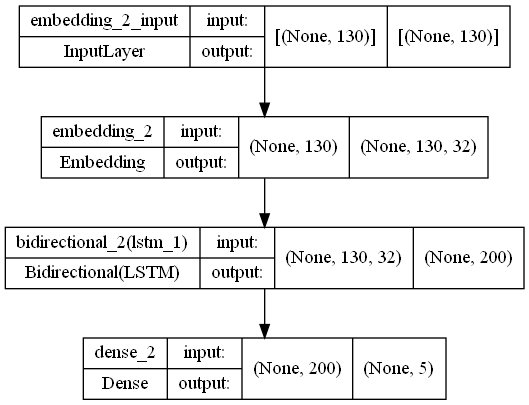

In [58]:
import tensorflow as tf
import pydot
import graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [36]:
#I evaluate the accuracy of the model with the test data
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Score']
y_test = keras.utils.np_utils.to_categorical(y_test)
prediction = model.predict(X_test)
prediction2 = (model.predict(X_test) > 0.5).astype("int32")
model.evaluate(X_test, y_test, batch_size=32)

3545/3545 [==============================] - 175s 49ms/step - loss: 0.7656 - accuracy: 0.7826


[0.7655892968177795, 0.7826378345489502]

In [38]:
arr = []
for i in prediction:
    x = np.argmax(i)
    arr.append(x)
    
arr2 = []
for i in y_test:
    x = np.argmax(i)
    arr2.append(x)

print("Model Accuracy: ", accuracy_score(arr, arr2))

Model Accuracy:  0.7826378296405364
